In [1]:
# Import Stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Load Data
data_1_4 = pd.read_csv("A1 data - data_1_4.csv")
data_2_12 = pd.read_csv("A1 data - data_2_12(1).csv")
data_3_12 = pd.read_csv("A1 data - data_3_12(1).csv")
data_2_8 = pd.read_csv("A1 data - data_2_8.csv")
data_compo = pd.read_csv("A1 data - data_com.csv")

In [3]:
# Get trials in data_1_4 to data 3_12
trials_data_1_4 = {}
trials_data_2_12 = {}
trials_data_3_12 = {}
trials_data_2_8 = {}
for i in range(1, 4):
    trials_data_1_4[f"trials_{i}_data_1_4"] = data_1_4.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_2_12[f"trials_{i}_data_2_12"] = data_2_12.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_3_12[f"trials_{i}_data_3_12"] = data_3_12.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_2_8[f"trials_{i}_data_2_8"] = data_3_12.loc[:, f'T{i}':f'Remaining{i}']

# For the composite there are only 1 trials each
one_decay = data_compo.loc[:, 'T_1d':'Remaining_1d']
two_decay = data_compo.loc[:, 'T_2d':'Remaining_2d']

In [4]:
# Process data
def standardize_and_combine(trials_dict):
    """
    Standardizes column names and combines multiple trials into one DataFrame.

    Parameters:
    trials_dict (dict): Dictionary where keys are trial names and values are DataFrames.

    Returns:
    pd.DataFrame: A combined DataFrame with aligned Time, mean Remaining, and std Remaining.
    """
    standardized_dfs = []  # List to store standardized DataFrames

    for trial_name, df in trials_dict.items():
        # Identify time and remaining columns dynamically
        time_col = [col for col in df.columns if col.startswith("T")][0]  # Find the time column
        remaining_col = [col for col in df.columns if "Remaining" in col][0]  # Find the remaining column
        
        # Rename columns to standardized names
        df = df.rename(columns={time_col: "Time", remaining_col: f"Remaining_{trial_name}"})
        
        # Append to list
        standardized_dfs.append(df)

    # Merge all DataFrames on "Time" using an outer join to include all time points
    combined_df = standardized_dfs[0]
    for df in standardized_dfs[1:]:
        combined_df = pd.merge(combined_df, df, on="Time", how="outer")

    # Compute the mean and standard deviation of the remaining dice
    remaining_cols = [col for col in combined_df.columns if col.startswith("Remaining_")]
    combined_df["Remaining_Mean"] = combined_df[remaining_cols].mean(axis=1, skipna=True)
    combined_df["Remaining_Std"] = combined_df[remaining_cols].std(axis=1, skipna=True)

    return combined_df

combined_df_1_4 = standardize_and_combine(trials_data_1_4)
combined_df_2_8 = standardize_and_combine(trials_data_2_8)
combined_df_2_12 = standardize_and_combine(trials_data_2_12)
combined_df_3_12 = standardize_and_combine(trials_data_3_12)

### Setup Simulation

In [12]:
# Number of Dice
N = 100
data = {}
    
def run(N, D_type, decay_states, data):
    faces_states = list(range(1, D_type+1))
    time = 0
    array_time = [0]
    array_N = [100]
    while N > 0:
        time += 1
        # Randomize choice
        dices = [np.random.choice(faces_states) for i in range(N)]
        # Remove dices
        dices = [face for face in dices if face not in decay_states]
        N = len(dices)
        # Append Data
        array_time.append(time)
        array_N.append(N)
    data[f"P = {len(decay_states)/D_type}"] = (array_time, array_N)

# Run all types
run(N, 4, [1], data)
run(N, 8, [1, 2], data)
run(N, 12, [1, 2], data)
run(N, 12, [1, 2, 3], data)

### Plot Data (Experimental)

In [6]:
def theo(time, P):
    """ 
    This is the exponential expected distribution
    """
    lambda_theo = P
    return 100*np.exp(-lambda_theo*time)
def geo_theo(P, EX):
    time = []
    N_remains = []
    N_theo = []
    N = 100
    counter = 0
    while N >= 1 and counter <= EX:
        time.append(counter)
        N_remains.append(N)
        N_theo.append(theo(counter, P))
        counter += 1
        N = int((1-(1/6))*N)
    return N_theo, N_remains, time

def plot_combined_decay(combined_df, P = 0.25, title = ""):
    """
    Plots the mean remaining dice with standard deviation as a shaded region.

    Parameters:
    combined_df (pd.DataFrame): The processed DataFrame with mean and std.
    """
    plt.figure(figsize=(10, 5))
    
    # Plot mean remaining dice
    plt.plot(combined_df["Time"], combined_df["Remaining_Mean"], marker='o', linestyle='-', color='b', label="Experimental Data")

    # Plot shaded standard deviation area
    plt.fill_between(combined_df["Time"],
                     combined_df["Remaining_Mean"] - combined_df["Remaining_Std"],
                     combined_df["Remaining_Mean"] + combined_df["Remaining_Std"],
                     color='b', alpha=0.2)

    
    N_theo, N_geo, time = geo_theo(P, len(combined_df['Time']))
    
    plt.plot(time, N_geo, marker = "+",label="Geometric")
    plt.plot(time, N_theo, marker = "x", label ="Exponential")
#     plt.semilogy()
    plt.xlabel("Time")
    plt.ylabel("Remaining Dice (N)")
    plt.title(f"Remaining Dice vs Time for P = {P:3f} [{title}]")
    plt.legend()
    plt.grid(True)
    plt.show()

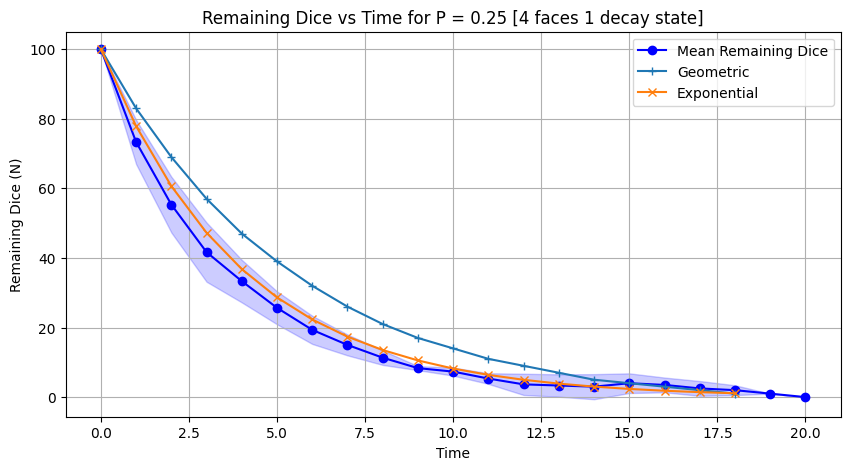

In [7]:
plot_combined_decay(combined_df_1_4, P = 1/4, title ="4 faces 1 decay state")

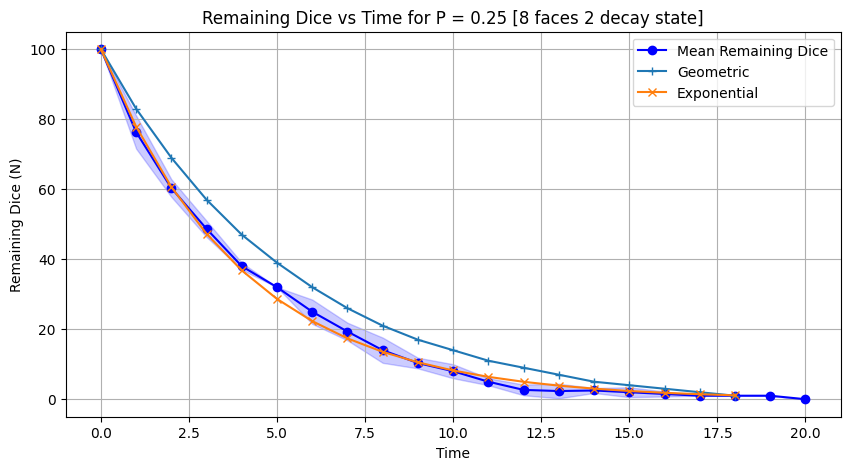

In [8]:
plot_combined_decay(combined_df_2_8, P = 2/8, title ="8 faces 2 decay state")

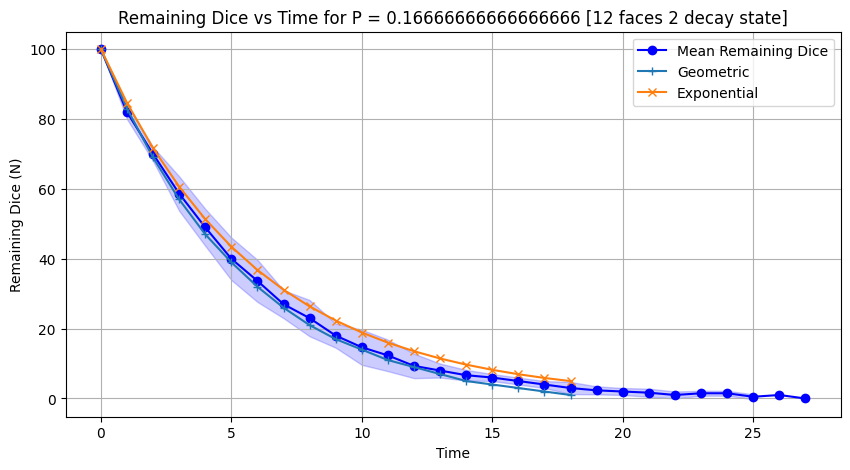

In [9]:
plot_combined_decay(combined_df_2_12, P = 2/12, title ="12 faces 2 decay state")

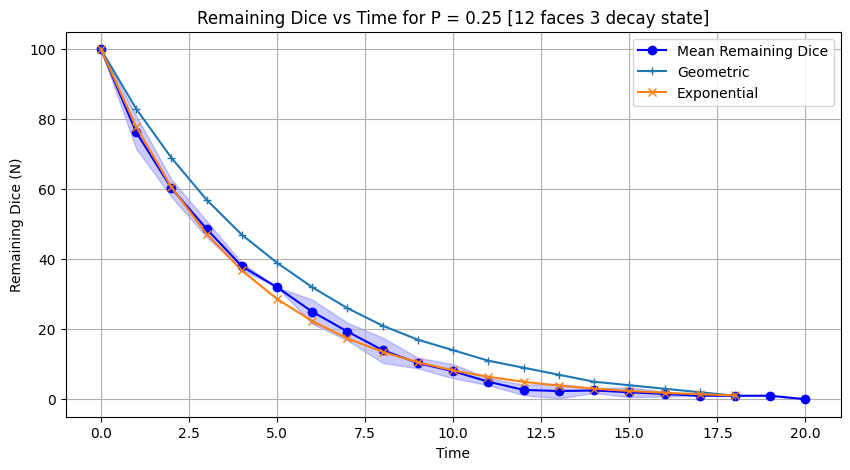

In [10]:
plot_combined_decay(combined_df_3_12, P = 3/12, title ="12 faces 3 decay state")

### Plot Data (Simulation

In [16]:
def plot_sim(simul, P, title = ""):
    time_prop = simul[0]
    N_data = simul[1]
    
    N_theo, N_geo, time = geo_theo(P, len(time_prop))
    plt.plot(time_prop, N_data, marker = "o", label = "Simulated Data")
    plt.plot(time, N_geo, marker = "+",label="Geometric")
    plt.plot(time, N_theo, marker = "x", label ="Exponential")
    plt.xlabel("Time")
    plt.ylabel("Remaining Dice (N)")
    plt.title(f"Remaining Dice vs Time for P = {P:3f} [{title}]")
    plt.legend()
    plt.grid(True)
    plt.show()

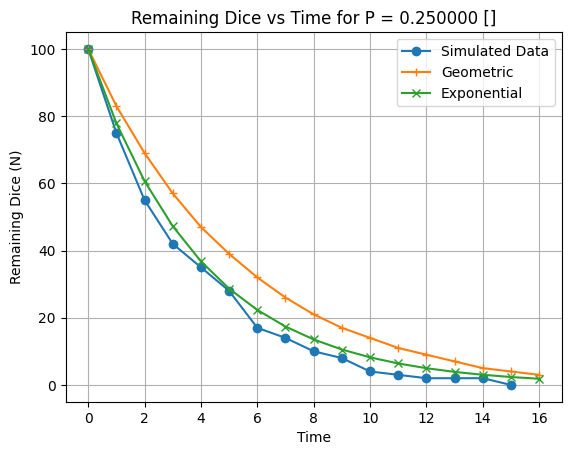

In [17]:
plot_sim(data[f"P = {1/4}"], 1/4)

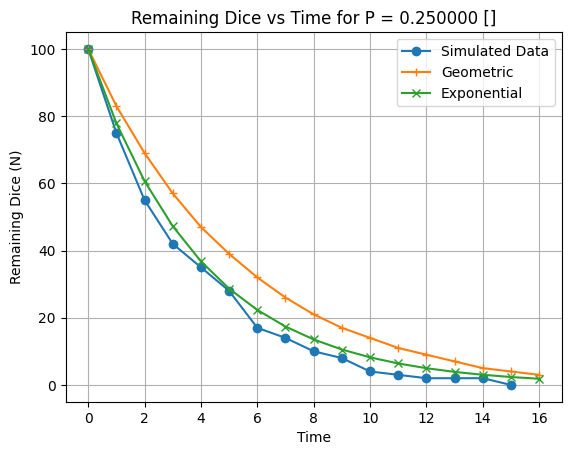

In [19]:
plot_sim(data[f"P = {2/8}"], 2/8)

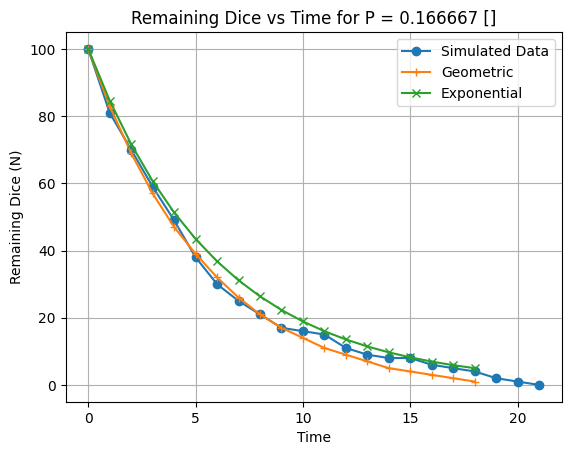

In [20]:
plot_sim(data[f"P = {2/12}"], 2/12)

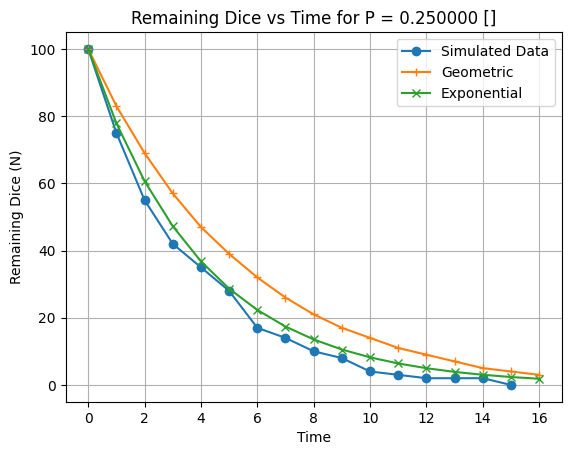

In [21]:
plot_sim(data[f"P = {3/12}"], 3/12)